In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

* Define class of kmeans

In [2]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1-x2)**2))

class Kmeans:

    def __init__(self, K=5, max_iters=100, plot_steps=False):
        self.K = K
        self.max_iters = max_iters
        self.plot_steps = plot_steps

        # list of sample indices for each cluster
        self.clusters = [[] for _ in range(self.K)]

        # the centers (mean vector) for each cluster
        self.centroids = []


    def predict(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape

        # initialize
        random_sample_idxs = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = [self.X[idx] for idx in random_sample_idxs]

        # optimize clusters
        for _ in range(self.max_iters):
            # assign samples to closest centroids (create clusters)
            self.clusters = self._create_clusters(self.centroids)

            # calculate new centroids from the clusters
            centroids_old = self.centroids
            self.centroids = self._get_centroids(self.clusters)

            if self._is_converged(centroids_old, self.centroids):
                break

        # classify samples as the index of their clusters
        return self._get_cluster_labels(self.clusters)


    def _get_cluster_labels(self, clusters):
        # each sample will get the label of the cluster it was assigned to
        labels = np.empty(self.n_samples)
        for cluster_idx, cluster in enumerate(clusters):
            for sample_idx in cluster:
                labels[sample_idx] = cluster_idx

        return labels


    def _create_clusters(self, centroids):
        # assign the samples to the closest centroids
        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters

    def _closest_centroid(self, sample, centroids):
        # distance of the current sample to each centroid
        distances = [euclidean_distance(sample, point) for point in centroids]
        closest_idx = np.argmin(distances)
        return closest_idx


    def _get_centroids(self, clusters):
        # assign mean value of clusters to centroids
        centroids = np.zeros((self.K, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids

    def _is_converged(self, centroids_old, centroids):
        # distances between old and new centroids, for all centroids
        distances = [euclidean_distance(centroids_old[i], centroids[i]) for i in range(self.K)]
        return sum(distances) == 0
    

* Load the Data

In [3]:
iris_df = pd.read_csv('Iris Dataset.csv')

In [4]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [5]:
# Remove unneccseary coulmn
iris_df.drop('Id',axis=1,inplace=True)

* Data pre-processing

In [6]:
iris_df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [7]:
iris_df.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


* check any cloumn is null or not

In [8]:
iris_df.isnull().sum()

SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

* show unique entries in each column

In [9]:
iris_df.nunique()

SepalLengthCm    35
SepalWidthCm     23
PetalLengthCm    43
PetalWidthCm     22
Species           3
dtype: int64

* Differeniate inputs and target column

In [10]:
y = iris_df.Species
X = iris_df.drop('Species',axis=1)

* Data Analysis

In [11]:
X.corr()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
SepalLengthCm,1.000000,-0.109369,0.871754,0.817954
SepalWidthCm,-0.109369,1.000000,-0.420516,-0.356544
PetalLengthCm,0.871754,-0.420516,1.000000,0.962757
PetalWidthCm,0.817954,-0.356544,0.962757,1.000000


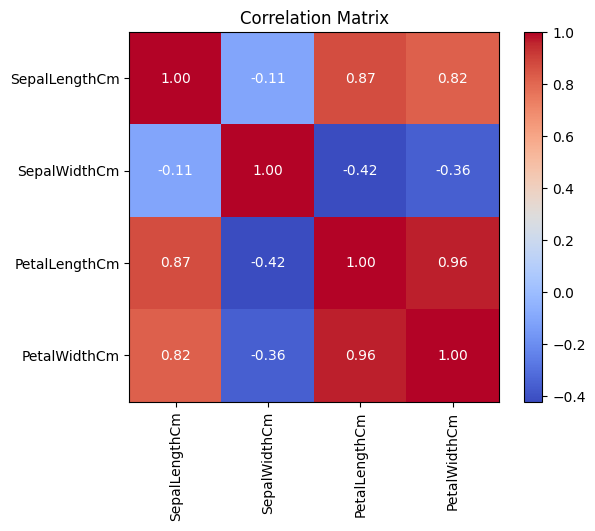

In [12]:
# plot correlation matrix
correlation_matrix = X.corr()
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()

annot = True
# Adding the correlation values as annotations
if annot:
    for i in range(len(X.columns)):
        for j in range(len(X.columns)):
            text = plt.text(j, i, "{:.2f}".format(correlation_matrix.iloc[i, j]),
                            ha="center", va="center", color="w")

plt.xticks(range(len(X.columns)), X.columns, rotation='vertical')
plt.yticks(range(len(X.columns)), X.columns)
plt.title('Correlation Matrix')

plt.show()


* Training The model

In [13]:
np.random.seed(42)
clusters =len(np.unique(y))
print(clusters)

3


In [14]:
# Convert X to a NumPy array
X = np.array(X)
k = Kmeans(K=clusters,max_iters=300)

In [15]:
y_pred = k.predict(X)

* Graph of Actual species(Target)

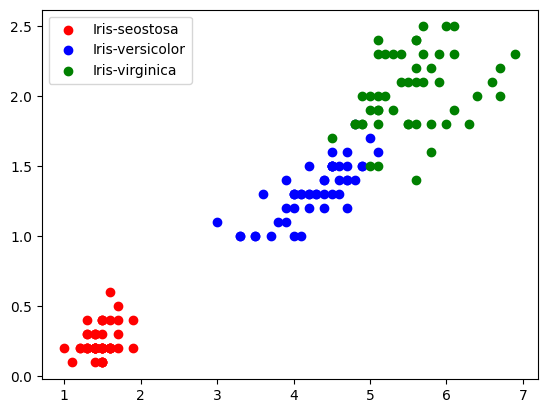

In [16]:
df1 = iris_df[iris_df['Species']=='Iris-setosa']
df2 = iris_df[iris_df['Species']=='Iris-versicolor']
df3 = iris_df[iris_df['Species']=='Iris-virginica']

plt.scatter(df1['PetalLengthCm'],df1['PetalWidthCm'],color='r',label='Iris-seostosa')
plt.scatter(df2['PetalLengthCm'],df2['PetalWidthCm'],color='b',label='Iris-versicolor')
plt.scatter(df3['PetalLengthCm'],df3['PetalWidthCm'],color='g',label='Iris-virginica')

plt.legend()
plt.show()

* Graph a output of clusters

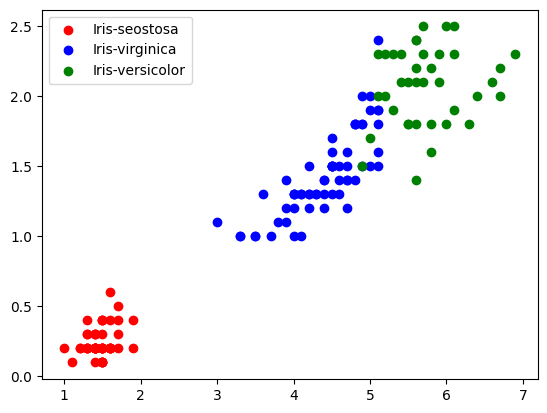

In [17]:
plt.scatter(X[y_pred==1,2],X[y_pred==1,3],color='r',label='Iris-seostosa')
plt.scatter(X[y_pred==0,2],X[y_pred==0,3],color='b',label='Iris-virginica')
plt.scatter(X[y_pred==2,2],X[y_pred==2,3],color='g',label='Iris-versicolor')


plt.legend()
plt.show()